In [1]:
import os
import numpy as np
from numpy.linalg import norm
import trimesh
import pybullet as p
from scipy.spatial.transform import Rotation as R
from numpy import pi

seed = np.random.randint(0, 10000)
print('SEED = ',seed)
np.random.seed(seed)
ASSET_ROOT = os.path.abspath('urdfc')

cube = trimesh.load(ASSET_ROOT+'/cube/tinker.obj')
cuboid = trimesh.load(ASSET_ROOT+'/cuboid/tinker.obj')
cylinder = trimesh.load(ASSET_ROOT+'/cylinder/tinker.obj')
ccuboid = trimesh.load(ASSET_ROOT+'/cut_cuboid/tinker.obj')
scuboid = trimesh.load(ASSET_ROOT+'/small_cuboid/tinker.obj')
tcuboid = trimesh.load(ASSET_ROOT+'/thin_cuboid/tinker.obj')
roof = trimesh.load(ASSET_ROOT+'/roof/tinker.obj')
pyramid = trimesh.load(ASSET_ROOT+'/pyramid/tinker.obj')

obj_primes = [cube, cylinder, ccuboid, scuboid, tcuboid, roof, pyramid, cuboid]
obj_vertcs = set([len(x.vertices) for x in obj_primes])
# [8, 40, 74, 8, 8, 66, 6, 8]
irg_vertc_map = {
    40: 'cylinder',
    74: 'ccuboid',
    66: 'roof',
    6: 'pyramid',
    8: '[regular]'
}

for x in obj_primes:
    x.apply_scale(0.001)

def get_transform(rotq=None, euler=None, rotvec=None, matrix=None, pos=(0,0,0)):
    trans = np.eye(4)
    
    if rotq is not None:
        trans[:-1,:-1] = R.from_quat(rotq).as_matrix()  
    elif euler is not None:
        trans[:-1,:-1] = R.from_euler('xyz', euler).as_matrix()
    elif rotvec is not None:
        trans[:-1,:-1] = R.from_rotvec(rotvec).as_matrix()
    elif matrix is not None:
        trans[:-1,:-1] = matrix
        
    trans[:-1,-1:] = np.array(pos).reshape(-1,1)
    
    return trans

def mesh_center(mesh):
    vert_count = len(mesh.vertices)
    center = None
    assert(vert_count in obj_vertcs)
    
    if irg_vertc_map[vert_count] == 'ccuboid':
        # cm to nearest
        cm = mesh.center_mass
        (center,),*_ = trimesh.proximity.closest_point(mesh, [cm])
        
#     elif irg_vertc_map[vert_count] in ['pyramid', 'roof']:
#         # xy from cm, heighest z value/2
#         vert_zs = mesh.vertices[:,-1]
#         hi_z = vert_zs.max()
#         lo_z = vert_zs.min()
        
#         mid_z = (hi_z+lo_z)/2
        
#         new_x, new_y, _ = mesh.center_mass
#         center = (new_x, new_y, mid_z)
    else:
        center = mesh.center_mass

    return np.array(center)
        
def to_origin(mesh):
    new_offt = mesh_center(mesh)
    mesh.apply_transform(get_transform(pos=-new_offt))
    
for x in obj_primes:
    to_origin(x)

omap = {
    'cube': cube,
    'cylinder': cylinder,
    'ccuboid': ccuboid,
    'scuboid': scuboid,
    'tcuboid': tcuboid,
    'roof': roof,
    'pyramid': pyramid,
    'cuboid': cuboid
}
assert(len(omap) == len(obj_primes))
def make_obj(otype, om=omap):
    return om[otype].copy()

SEED =  2023


pybullet build time: Nov 30 2022 16:56:59


In [2]:
def get_path(vpath, mesh):
    return trimesh.load_path(mesh.vertices[vpath])

def recreate(objs):
    oid_to_mesh = {}
    
    for oid, oty in objs:
        mesh = make_obj(oty)
        
        m_pos, m_ori = p.getBasePositionAndOrientation(oid)
        mesh.apply_transform(get_transform(rotq=m_ori, pos=m_pos))
        
        oid_to_mesh[oid] = mesh
        
    sc = trimesh.Scene(list(oid_to_mesh.values()))
        
    return bidict(oid_to_mesh), sc

In [3]:
pyramid_lom = {
    60: [(0,0,0)],
    round(60/np.sqrt(2)): [(0,3*pi/4,0), (0,-3*pi/4,0)],
    30: [(pi/2,0,0), (-pi/2,0,0)],
    20: [(0,0,pi/2), (0,3*pi/4,pi/2), (0,3*pi/4,-pi/2)]
}

cylinder_lom = {
    30: [(0,0,0)]
}

cube_lom = {
    30: [(0,0,0)]
}

cuboid_lom = {
    30: [(0,0,0), (0,pi/2,pi/2)],
    60: [(0,pi/2,0)]
}

ccuboid_lom = {
    30: [(0,0,0),(0,0,-pi/2),(0,0,pi/2),(0,0,pi),(0,pi/2,pi/2),(0,-pi/2,pi/2)], # last is smooth face down, second to last is smooth face up like |
    60: [(0,pi/2,0),(0,-pi/2,0),(pi/2,0,pi/2),(pi/2,pi,pi/2)] # smooth side up down (first 2) like --
}

scuboid_lom = {
    15: [(0,pi/2,0)],
    30: [(0,0,0), (0,pi/2,pi/2)]
}

tcuboid_lom = {
    15: [(0,0,pi/2),(0,pi/2,pi/2)],
    30: [(0,0,0), (pi/2,0,0)],
    60: [(0,pi/2,0), (pi/2,0,pi/2)]
}

roof_lom = {
    30: [(0,0,pi/2)],
    40: [(0,0,0)]
    # variable lengths like pi/2,0,0 not included for simplicity
}

# maps (obj_string) to (length -> orientations) map
ot_lom_map = {
    'cube': cube_lom,
    'cuboid': cuboid_lom,
    'ccuboid': ccuboid_lom,
    'scuboid': scuboid_lom,
    'tcuboid': tcuboid_lom,
    'pyramid': pyramid_lom,
    'roof': roof_lom,
    'cylinder': cylinder_lom
}

poss_lens = np.array(list(set().union(*ot_lom_map.values())))

# maps (length) to (list[obj_string] containing orientations with such lengths)
len_objtypes_map = {l:[] for l in poss_lens}

for l,offerings in len_objtypes_map.items():
    for ot,ot_lom in ot_lom_map.items():
        if l in ot_lom:
            offerings.append(ot)

In [4]:
import os
import pybullet as p
import pybullet_data
from numpy import pi
from bidict import bidict
import time

class PBObjectLoader:
    def __init__(self, asset_root):
        self.obj_ids = []
        self.obj_typ = []
        self.asset_root = os.path.abspath(asset_root)
        
    def load_obj(self, otype, pos=(0,0,0), ori=(0,0,0,1), wait=0):
        if isinstance(ori, list):
            ori = p.getQuaternionFromEuler(ori)
        
        oid = p.loadURDF(os.path.join(self.asset_root, f'{otype}.urdf'), pos, ori)

        for _ in range(wait):
            p.stepSimulation()
            time.sleep(1./240.)
            
        self.obj_ids.append(oid)
        self.obj_typ.append(otype)
            
        return oid
    
    def get_objs(self):
        return list(zip(self.obj_ids, self.obj_typ))

PLANE_ROOT = os.path.abspath('urdf')

physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-9.81)

target = (-0.07796166092157364, 0.005451506469398737, -0.06238798052072525)
dist = 1.0
yaw = 89.6000747680664
pitch = -17.800016403198242
p.resetDebugVisualizerCamera(dist,yaw,pitch,target)

planeId = p.loadURDF(os.path.join(PLANE_ROOT, 'plane/plane.urdf'))

loader = PBObjectLoader('urdfc')

otypes = list(omap.keys())
loader.load_obj(np.random.choice(otypes), pos=[0.05, 0, 0.01], ori=[0, 0, 0])
loader.load_obj(np.random.choice(otypes), pos=[0, 0, 0.01], ori=[0, 0, 0], wait=100)
# loader.load_obj('cube', pos=[0.025, 0, .1], ori=[pi/2, pi/2, 0], wait=100)

om_map, sc = recreate(loader.get_objs())

time.sleep(1)
p.disconnect()

sc.show()
scOrig = sc.copy()

In [186]:
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist
from numpy.linalg import norm
from scipy.spatial.transform import Rotation as R
from scipy.linalg import lstsq
from scipy.optimize import least_squares

def top_faces_idx(mesh):
    facet_n = mesh.facets_normal
    up_n = facet_n[facet_n[:,-1].argmax()]
    face_n = mesh.face_normals
    
    return np.all(np.isclose(face_n, up_n), axis=1).nonzero()

def bottom_faces_idx(mesh):
#     facet_n = mesh.facets_normal
    
#     down_n = facet_n[facet_n[:,-1].argmin()]
#     face_n = mesh.face_normals
    # if facet is triangle, it is not included
    down_n = [0,0,-1] # down  guaranteed now with lom
    
    return np.all(np.isclose(face_n, down_n), axis=1)

def bottom_faces_fcentroid(mesh):
    f_idx = bottom_faces_idx(mesh)
    
    b_faces = mesh.faces[f_idx]
    bf_vert = mesh.vertices[b_faces]
    bf_cens = bf_vert.mean(axis=1)
    
    return bf_cens.mean(axis=0)

def closest_point(set1, set2):
    dists = cdist(set1, set2)
    min_i, min_j = np.unravel_index(dists.argmin(), dists.shape)
    
    return min_i, min_j

def closest_points_idx(set1, set2, n):
    dists = cdist(set1, set2)
    indices = dists.flatten().argsort()[:n]
    indices = np.unravel_index(indices, dists.shape)
    
    return indices

def sample_infaces(mesh, faces_idx, num_points):
    face_areas = mesh.area_faces[faces_idx]
    face_probs = face_areas/np.sum(face_areas)
    
    ar_w = np.zeros_like(mesh.area_faces)
    ar_w[faces_idx] = mesh.area_faces[faces_idx]

    points, faces_idx = mesh.sample(num_points, return_index=True, face_weight=ar_w)
    
    return points, faces_idx

def fit_plane(points):
    centroid = points.mean(axis=0)
    _, values, vectors = np.linalg.svd(points - centroid)
    normal = vectors[2]
    d = -np.dot(centroid, normal)
    plane = np.append(normal, d)

    return plane

def get_place_plane(mesh1, mesh2, sim_tol=5e-01, n_closest=10, n_samples=100):
    m1_maxh = mesh1.vertices[:,:-1].max()
    m2_maxh = mesh2.vertices[:,:-1].max()
    
    m1_topf_idx = top_faces_idx(mesh1)
    m2_topf_idx = top_faces_idx(mesh2)
    
    heights_sim = abs(m1_maxh - m2_maxh) < sim_tol
    place_plane = None
    
    m1p, m1pf = sample_infaces(mesh1, m1_topf_idx, n_samples)
    m2p, m2pf = sample_infaces(mesh2, m2_topf_idx, n_samples)
    
    cp_1, cp_2 = closest_points_idx(m1p, m2p, n_closest)
    plane_points = np.concatenate([m1p[cp_1], m2p[cp_2]])
        
    # weight invariant
    pp_f = np.append(m1pf[cp_1], m2pf[cp_2])
    pp_f = pp_f == pp_f[0]
    pp_f1p = plane_points[pp_f].mean(axis=0)
    pp_f2p = plane_points[~pp_f].mean(axis=0)
    
    pp_cen = (pp_f1p+pp_f2p)/2
    pp_eqn = fit_plane(plane_points)
    pp_dis = norm(pp_f1p-pp_f2p)
    
    print(heights_sim)
    
    return pp_eqn, pp_cen, plane_points, pp_dis, heights_sim

o1, o2 = loader.obj_ids

def get_align_transform(p_mesh, pp_eqn, pp_cen):
    bf_cen = bottom_faces_fcentroid(p_mesh)
    bfc_to_ori = get_transform(pos=-bf_cen)
    
    *normal,_ = pp_eqn
    p_u = normal/norm(normal)
    xy_u = np.array([0,0,1])
    
    rotv = np.cross(xy_u, p_u)
    rotv /= norm(rotv)
    
    angle = np.arccos(xy_u@p_u)
    while angle > np.pi/2:
        angle -= np.pi
        
    rotv *= angle
    
    plane_rot = get_transform(rotvec=rotv, pos=pp_cen)
    
    print(bfc_to_ori)
    
    return bf_cen, bfc_to_ori
#     return plane_rot@bfc_to_ori

col1, col2 = [om_map[x] for x in loader.obj_ids]

def pspheres(points, radius=.0005):
    return [trimesh.primitives.Sphere(radius=radius, center=pt) for pt in points]

def get_obj_pose(col1, col2):
    # get plane for placement
    pp_eqn, pp_cen, pp_points, pp_dis, heights_sim = get_place_plane(col1, col2)

    # decide which object to place
    pp_dis *= 1000
    len_diffs = poss_lens-pp_dis
    len_diffs[len_diffs < 0] = np.inf

    # select object type depending on length
    closest_len = poss_lens[len_diffs.argmin()]
    po_type = np.random.choice(len_objtypes_map[closest_len])
    po_type = 'pyramid'
    print(po_type, 'type')

    # select desirable orientation for object
    orn_choices = ot_lom_map[po_type][closest_len]
    po_orn = orn_choices[np.random.choice(len(orn_choices))]
    print(po_orn, 'initial orn')

    # get transformation for beginning object pose
    p_obj = omap[po_type].copy()
    se3 = get_transform(euler=po_orn)
    p_obj_copy = p_obj.copy() # align_trans depends on bottom face being correct
    p_obj_copy.apply_transform(se3)

    # get transformation to place object
    bf_cen, align_trans = get_align_transform(p_obj_copy, pp_eqn, pp_cen)
    
    align_trans = align_trans@se3
    
#     align_trans = se3
    
    # get quaternion and position information
    quat = R.from_matrix(align_trans[:-1,:-1]).as_quat()
    pos = align_trans[:-1,-1:].flatten()

    # place object on plane
    p_obj.apply_transform(align_trans)

    sc1 = scOrig.copy()
    sc1.add_geometry(pspheres(pp_points))
    sc1.add_geometry(pspheres([pp_cen]))
    sc1.add_geometry([p_obj])

#     sc1.add_geometry([pspheres([(0,0,0)], radius=0.002)])
    sc1.add_geometry([pspheres([bf_cen], radius=0.002)])

    return sc1

get_obj_pose(col1, col2).show()

True
pyramid type
(1.5707963267948966, 0, 0) initial orn
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  3.98986399e-17]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -2.94902991e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [272]:
def bottom_faces_idx(mesh):
#     facet_n = mesh.facets_normal
    
#     down_n = facet_n[facet_n[:,-1].argmin()]
#     face_n = mesh.face_normals
    # if facet is triangle, it is not included
    down_n = [0,0,-1] # down  guaranteed now with lom
    
    return np.all(np.isclose(face_n, down_n), axis=1)

def bottom_faces_fcentroid(mesh):
    f_idx = bottom_faces_idx(mesh)
    
    b_faces = mesh.faces[f_idx]
    bf_vert = mesh.vertices[b_faces]
    bf_cens = bf_vert.mean(axis=1)
    
    return bf_cens.mean(axis=0)

pyrc = pyramid.copy()
t = get_transform(euler=(1.5707963267948966, 0, 0))
# t = get_transform(euler=(0, 0, 0))
pyrc.apply_transform(t)

sc2 = trimesh.Scene([pyrc])
sc2.add_geometry([pspheres([bottom_faces_fcentroid(pyrc)], radius=0.002)])

sc2.show()

In [6]:
t = {i:[] for i in range(5)}

nu = [3,2,1,6,8]

for (k,v), n in zip(t.items(), nu):
    for x in range(n):
        v.append(x)
        
print(t)

{0: [0, 1, 2], 1: [0, 1], 2: [0], 3: [0, 1, 2, 3, 4, 5], 4: [0, 1, 2, 3, 4, 5, 6, 7]}


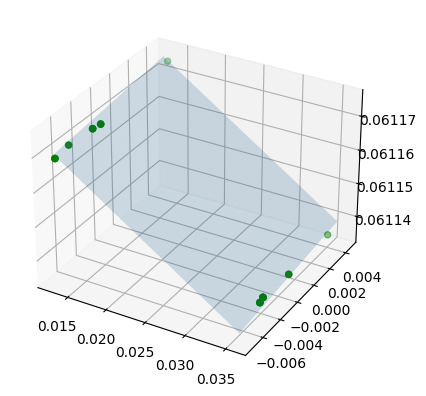

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# create x,y
x = np.linspace(min(pp_points[:,0]), max(pp_points[:,0]), 100)
y = np.linspace(min(pp_points[:,1]), max(pp_points[:,1]), 100)
xx, yy = np.meshgrid(x, y)

# calculate corresponding z
a,b,c,d = pp_eqn
z = (-a * xx - b * yy - d) * 1./c

# plot the surface
fig = plt.figure()

# Add an axes
ax = fig.add_subplot(111,projection='3d')

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.2)

# and plot the point 
ax.scatter(pp_points[:,0], pp_points[:,1], pp_points[:,2],  color='green')